# Fast AI Study 

## LESSON 1: What's your pet

---

### **2020년 03월 28일**

### **학습 목표**

1. 애완동물의 품종을 구분하는 **SOTA (state-of-the-art)** 성능의 이미지 분류기를 만들어본다.
2. fast.ai의 분석 주기와 인자들을 조정하는 방법을 배운다.
3.  ($+ a$) 직접 데이터를 수집하여 분류기를 만들어본다. 

### **목차**

  0. Overview
  1. `fast.ai` Quick Start 
  2. `fast.ai` Advanced Start  
  3. MNIST Dataset
  4. Reference


# 0. Overview

## fast.ai 란?

fast.ai는 최첨단의 딥러닝 기술을 누구나 쉽게 이용할 수 있도록 하는 것을 목표로 하며, [강의](https://course.fast.ai/)와 [라이브러리](https://github.com/fastai/fastai)를 제공합니다. 


`fastai` 라이브러리는 `pytorch`를 기반으로 만들어졌기 때문에 GPU 연산을 지원합니다.  그렇기 때문에 실습 시 GPU를 갖춘 클라우드 서버 환경을 권장하기 때문에, 이에 적합한 환경인 **Colab**을 기본 환경으로 문서를 작성하겠습니다.


## 실습 환경: **Colab** + **Google Drive**

<p>
    <img src="https://colab.research.google.com/img/colab_favicon_256px.png", width="100">
    <img src="https://upload.wikimedia.org/wikipedia/commons/d/da/Google_Drive_logo.png", width="100">
</p>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
from pathlib import Path

week = 1

root_dir = Path("/content/gdrive/My Drive/Colab Notebooks/" )
base_dir = root_dir / 'B-Cube-DA-1'

path = base_dir / f"Week {week}"
data_path = path / "data"

## Jupyter Notebook

[Jupyter Notebook](https://jupyter.org/)은 실시간으로 코드를 실행하고 결과를 볼 수 있는 환경을 제공합니다. 

### 단축키 및 알아두면 좋은 내용

- 단축키
  - <kbd>Shift</kbd>+<kbd>Enter</kbd>: 코드 및 마크다운 렌더링을 실행하고 다음 셀로 넘어갑니다
  - <kbd>Cntl</kbd>+<kbd>Enter</kbd>: 코드 및 마크다운 렌더링을 실행하고 다음 셀로 넘어가지 않습니다.

- 알아두면 좋은 기능
  + `??`: 모듈에 속한 함수들이 어떻게 동작하는지 해당 코들 간략하게 볼 수 있습니다.
  + `doc()` : 해당 함수에 대한 공식 문서를 보여줍니다.





### Magics

**Magic Command**는 셀에서 실행할 수 있고 나머지 라인들에서도 효력을 발휘하는 **Line**, 그리고 해당 셀에서만 효과가 있는 **Cell**로 구분할 수 있습니다. **Line**의 경우 `%`로 시작되며, **Cell**은 `%%`로 시작됩니다. 더 자세한 설명은 [공식 문서](https://ipython.readthedocs.io/en/stable/interactive/magics.html)를 참고하시면 됩니다.

아래의 ***Line Magic*** 명령어는 다음을 의미합니다.

- `%reload_ext autoreload`, `%autoreload 2`: 새로운 라인을 시작하기 전에 모든 모듈을 다시 불러옵니다. 
- `%matplotlib inline`: 모든 `matplotlib`의 그래프가 각 셀의 결과에 출력되며, 노트북이 저장됐을 경우에도 유지됩니다. 

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

- ***Cell Magic*** 

In [4]:
%%javascript 

let a = 1
let b = 2

console.log(a + b)

<IPython.core.display.Javascript object>

# 1. `fastai` Quick Start

---

- 데이터 준비 (`DataBunch`)
- 모델 생성 및 학습 (`Learner`)
- 모델 해석 (`ClassificationInterpretation`)


In [5]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 33.8MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101


In [6]:
from fastai.vision import *
from fastai.metrics import error_rate

bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## 1.1. 데이터 준비


사용할 데이터는 [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)에서 사용된 [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) 데이터입니다.  이 데이터는 12종의 고양이와 25종의 개를 가지고 있고, 만들어볼 모델은 이러한 37가지의 다른 종들을 구별해 낼 것입니다. 해당 논문의 연구결과에 따르면, 2012년의 가장 높은 정확도는 **59.21%** 였습니다. 이는 "이미지", "머리", 그리고 "몸"을 사진으로부터 분리해서 만들어낸 복잡한 모델로 낸 결과입니다. 우리는 이제 딥러닝을 이용해 얼마나 정확성을 높일 수 있는지 보도록 할 것입니다!


데이터를 불러오기 위해 `untar_data` 함수를 사용할 것입니다. 이 함수에 URL을 인자로서 넘겨주면, 거기로부터 자동으로 데이터를 다운 받고 추출하게 됩니다.



In [7]:
# help(untar_data)
# ??untar_data

In [8]:
path = untar_data(URLs.PETS)
path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [9]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [10]:
path_anno = path/'annotations'
path_img = path/'images'

- `DataBunch` 생성

파일의 라벨링 규칙을 확인한 결과 **정규표현식**을 사용해야 하며, 이를 통해 `DataBunch` 생성

In [11]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_75.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/samoyed_22.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_25.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_17.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Siamese_135.jpg')]

In [12]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [13]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

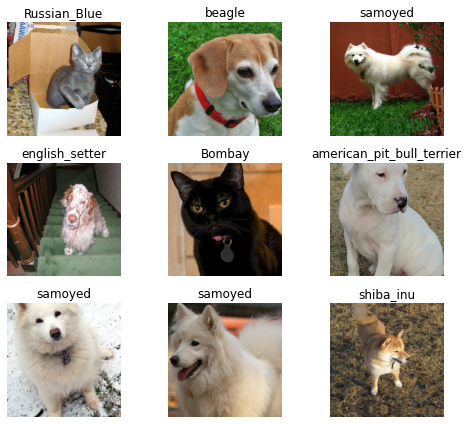

In [14]:
data.show_batch(rows=3, figsize=(7,6))

In [15]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## 1.2. 모델 생성 및 학습

이제 모델을 생성하고 학습시켜보도록 하겠습니다. [Convolutional Neural Network](http://cs231n.github.io/convolutional-networks)를 뼈대로하고 하나의 히든 레이어를 분류기로 사용하여 완전히 연결된 머릿단으로 할 것입니다. 이것이 무엇을 의미하는지 잘 모르겠다면? 차후 강의에 더 자세히 공부해볼 것이므로 걱정하지 않아도 됩니다. 지금 당장은 이미지를 입력으로 사용하고 각 범주에 대해 예측 된 확률을 출력하는 모델을 작성하고 있다는 것만 알아두면 됩니다(37개의 출력을 가지는).
4번의 에포크(전체 데이터를 4번 학습함)로 가지고 학습해 보도록 하겠습니다.

- 추가 설명
  + `ConvLearner` -> `cnn_learner`
  + **metrics**는 학습간에 어떤 출력을 보여줄지
  + learner에서 모델, 즉 아키텍쳐를 선택하면 미리 다량의 데이터로 학습된 결과물을 다운받는다. 
  + learner 함수들은 내부적으로 `Learner` 클래스를 호출하며 `load()` 함수를 포함하고 있다. 

In [16]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [17]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.334864,0.315261,0.099459,01:48
1,0.592425,0.288293,0.092016,01:48
2,0.382742,0.250963,0.077131,01:49
3,0.269931,0.226207,0.075101,01:50


In [18]:
learn.save(base_dir/ 'stage-1', return_path=True)

PosixPath('/content/gdrive/My Drive/Colab Notebooks/B-Cube-DA-1/stage-1.pth')

## 1.3. 모델 해석 

`fastai` 라이브러리는 모델을 학습하는하는 것에서 끝나는 것이 아니라, 이를 분석할 수 있는 기능 또한 포함하고 있습니다. 

먼저 모델이 가장 혼란스러워한 카테고리를 살펴 보겠습니다. 우리는 모델이 예측 한 것이 합당한 지 아닌지를 확인하려고 노력할 것입니다. 이 경우 실수는 합리적으로 보입니다 (오답들이 확실히 틀렸다고 보이지는 않습니다). 이것은 분류기가 올바르게 작동하고 있음을 나타내는 지표입니다.

또한 Confusion Matrix를 그래프로 나타내면 분포가 심하게 왜곡되어 있음을 알 수 있습니다. 모형이 반복해서 동일한 실수를 반복하지만 다른 범주를 혼동하는 경우는 거의 없습니다. 이것은 특정 범주를 서로 구분하기가 어렵다는 것을 암시합니다. 이것은 정상적인 동작입니다.

In [19]:
interp = ClassificationInterpretation.from_learner(learn) 

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs) # 해석에는 validatoin set 을 사용함

True

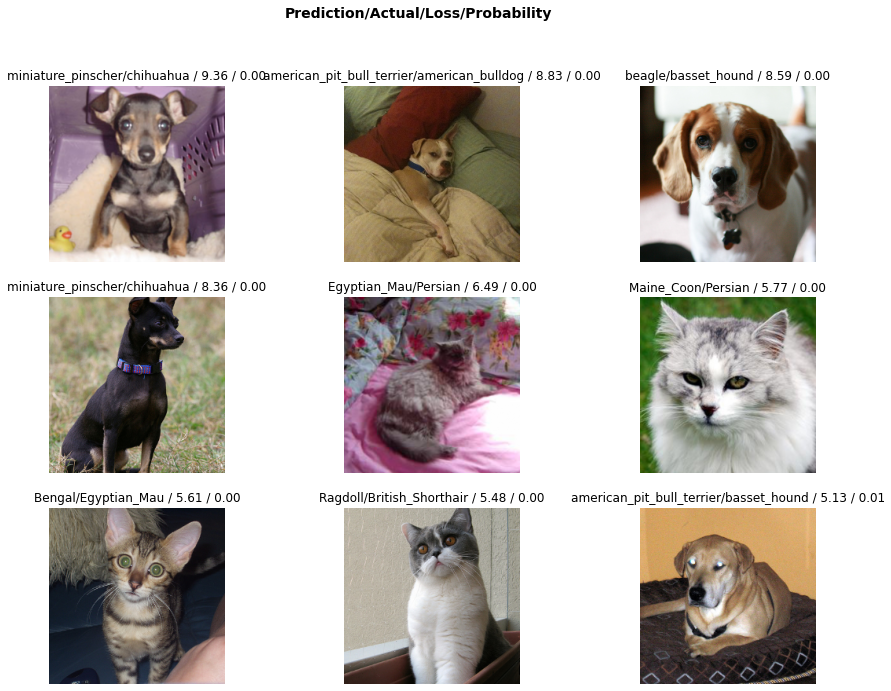

In [20]:
interp.plot_top_losses(9, figsize=(15,11))

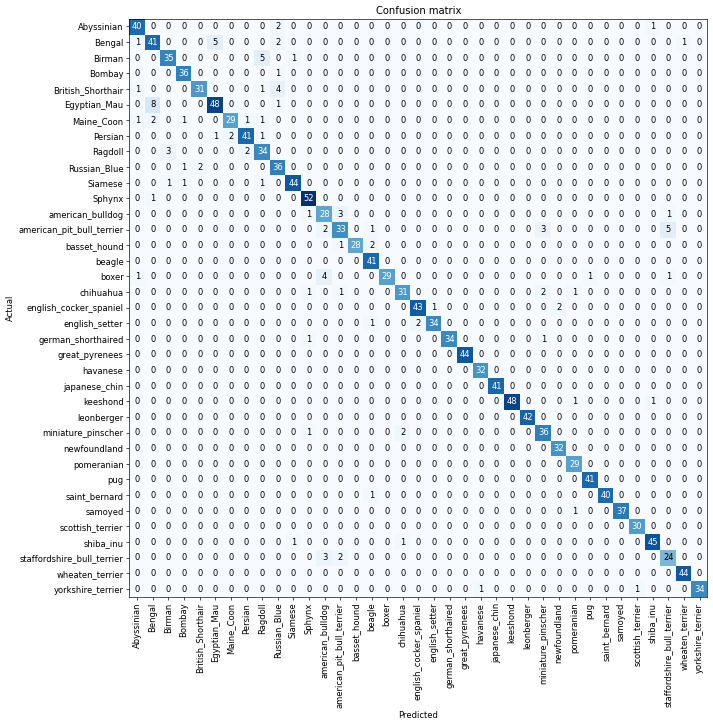

In [22]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
interp.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 8),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Birman', 'Ragdoll', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('boxer', 'american_bulldog', 4),
 ('Ragdoll', 'Birman', 3),
 ('american_bulldog', 'american_pit_bull_terrier', 3),
 ('american_pit_bull_terrier', 'miniature_pinscher', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('Abyssinian', 'Russian_Blue', 2),
 ('Bengal', 'Russian_Blue', 2),
 ('Maine_Coon', 'Bengal', 2),
 ('Persian', 'Maine_Coon', 2),
 ('Ragdoll', 'Persian', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('basset_hound', 'beagle', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('english_cocker_spaniel', 'newfoundland', 2),
 ('english_setter', 'english_cocker_spaniel', 2),
 ('miniature_pinscher', 'chihuahua', 2),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 2)]

# 2. `fast.ai` Advanced Start

---

## 2.1. Unfreezing, fine-tuning, and learning rates

- unfreezing 
  + 참고자료
    + [레딧](https://www.reddit.com/r/learnmachinelearning/comments/a0sqg4/what_is_freezing_layers_in_fastai/)
    + [포럼](https://forums.fast.ai/t/why-do-we-need-to-unfreeze-the-learner-everytime-before-retarining-even-if-learn-fit-one-cycle-works-fine-without-learn-unfreeze/41614) 
  + 설명
    + 기본적으로는 아키텍쳐 및 레이어에서 기존에 학습된 weight를 고정시켜서 특징을 활용하고, 머릿단의 분류 레이어만 학습시켜서 사용하게 된다. 그런데 unfreeze를 하게 되면 이러한 고정이 풀리게되고 전체적인 학습이 이루어지게 된다. 



In [24]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.674222,0.404822,0.127876,01:56


In [26]:
learn.load(base_dir / 'stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
yorkshire_terrier,samoyed,British_Shorthair,Bengal,Maine_Coon
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pug,staffordshire_bull_terrier,Abyssinian,pug,wheaten_terrier
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 

In [28]:
learn.unfreeze()


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 1.00E-06


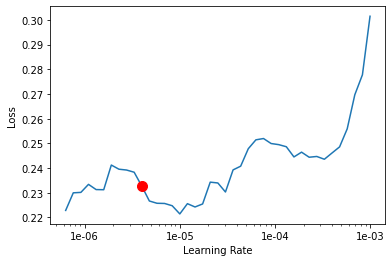

In [29]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [30]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.231673,0.228974,0.069689,01:54
1,0.218676,0.222038,0.068336,01:54


## 2.2. Change Architecture

Deep Learning은 층이 깊어질 수록 더욱 해당 Task를 잘 학습하는 방향으로 발전하게 되었고, 가장 대표적인 아키텍쳐는 [ResNet](https://arxiv.org/pdf/1512.03385.pdf)일 것입니다. 이 아키텍쳐는 층이 깊어질수록 성능이 떨어졌던 기존의 아키텍쳐들의 문제를 해결하여 층이 깊어질수록 더 좋은 효과를 내고 있습니다. **ResNet**에 대해서는 차후의 강의에서 더욱 심도깊게 다룰 것이고, 지금은 품종분류에서 더 좋은 성능을 낼 수 있도록 `resnet34` 에서 `resnet50`으로 아키텍쳐를 바꿔서 학습을 해보도록 하겠습니다. 혹시 이에 관한 읽을 자료가 필요하시다면 이미지 분류 모델의 발전 과정에 대한 [블로그 포스트](https://dnddnjs.github.io/cifar10/2018/10/09/resnet/ )를 참조하시면 좋을 것 같습니다.

더욱 깊어진 아키텍쳐로 인해서 GPU 메모리가 부족하다는 경고를 보게 된다면, batch 사이즈를 줄여서 이를 해결할 수 있습니다. 

In [31]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [32]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


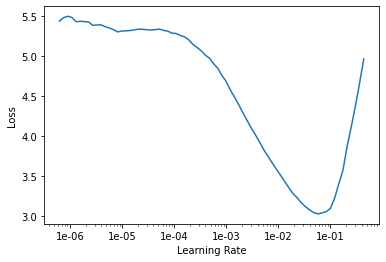

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.712203,0.294179,0.090663,03:29
1,0.556509,0.274805,0.090663,03:24
2,0.417572,0.247592,0.071719,03:25
3,0.321960,0.233928,0.066982,03:23
4,0.245860,0.173495,0.052097,03:24
5,0.216820,0.164786,0.050744,03:24
6,0.112474,0.156640,0.048038,03:26
7,0.104310,0.155098,0.046685,03:22


In [35]:
learn.save(base_dir / 'stage-1-50')

- unfreeze 적용

In [36]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.107748,0.152230,0.042625,04:33
1,0.111072,0.146405,0.044655,04:29
2,0.094116,0.141423,0.044655,04:28


In [37]:
learn.load(base_dir / 'stage-1-50')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
yorkshire_terrier,samoyed,British_Shorthair,Maine_Coon,Bengal
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
pomeranian,yorkshire_terrier,Bengal,pomeranian,Ragdoll
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), str

In [38]:
interp = ClassificationInterpretation.from_learner(learn)

In [39]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('staffordshire_bull_terrier', 'american_bulldog', 6),
 ('basset_hound', 'beagle', 5),
 ('Bengal', 'Egyptian_Mau', 4),
 ('Ragdoll', 'Birman', 4),
 ('Ragdoll', 'Persian', 4),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('boxer', 'american_bulldog', 3),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 2)]

# 3. $(+\alpha)$ MNIST Dataset

---
유명한 손글씨 분류 데이터셋인 MNIST 데이터셋으로 손글씨 분류기를 만들어보도록 하겠습니다. 여기서는 학습과정보다 다양한 방법으로 데이터를 준비하는 과정을 유의하여 보면 좋을 것 같습니다.

In [40]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/root/.fastai/data/mnist_sample')

In [41]:
tfms = get_transforms(do_flip=False)

## 3.1. `from_folder`

손글씨 데이터는 좌우 반전등의 데이터 변형 기법들이 적용되면 안되기 때문에, `get_transforms(do_filp=False)` 를 이용합니다.

In [42]:
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

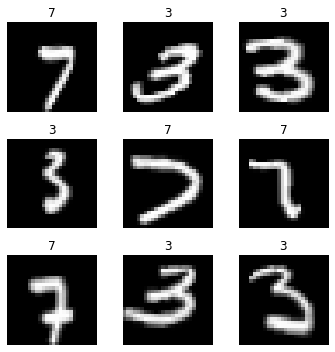

In [43]:
data.show_batch(rows=3, figsize=(5,5))

이번에는 `error_rate`가 아닌 `accuracy`를 표시해보도록 하였습니다. 

In [44]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.202372,0.095974,0.964671,00:25
1,0.115388,0.060530,0.980373,00:23


## 3.2. `from_csv`

In [45]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

## 3.3. `from_df`

In [46]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [47]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

## 3.4. `from_name_re`

In [48]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/root/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3/21102.png')]

In [49]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

## 3.5. `from_name_func`

In [50]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [51]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

## 3.6. `from_list`

In [52]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']

# 4. 이미지 다운로드  

위에서 지정해 두었던 base_dir에 붙여서 사용
pathlib은 fastai에 포함되어 있다. 아까 *로 모든 모듈을 다 불러왔음로, `Path()`를 사용하여 path를 만들어주자.

구글에서 검색어에 해당하는 이미지들을 자동으로 수집해주는 `icrawler`를 사용해보았습니다.

```python

from icrawler.builtin import GoogleImageCrawler

print("\nGoogle Image Crawler\n---------------------------------\nVer1 By Zikx\n---------------------------------\n")

word = input("Search : ")
dir_name = ".\data"
num = 1000

google_crawler = GoogleImageCrawler(
        feeder_threads=1,
        parser_threads=1,
        downloader_threads=4,
        storage={'root_dir': dir_name})

google_crawler.crawl(keyword=word, offset=0, max_num=num,
                    min_size=(200,200), max_size=None, file_idx_offset=0)

```

# Reference

---



### 수업 자료

- 강의 영상 [비디오](https://course.fast.ai/videos/?lesson=1)
- 강의 상세 설명 [Git 문서](https://github.com/hiromis/notes/blob/master/Lesson1.md)
- Pytorch 공식 튜토리얼 [문서](https://pytorch.org/tutorials/beginner/nn_tutorial.html)